In [1]:
import numpy as np
import scipy.sparse as sps
import h5py
from termcolor import colored

def decode_str(hdf5_str):
    return hdf5_str.tobytes().decode('utf-16')

filename = '../TROTS/data/Head-and-Neck/Head-and-Neck_07.mat'
# filename = '../Prostate_CK/Prostate_CK_02.mat'
# filename = 'Liver/Liver_01.mat'

f = h5py.File(filename)
print(colored('Patient: ' + decode_str(f['patient']['Identifier'][:]), 'blue'))

Patient: Head-and-Neck 07


In [2]:
class Region:
    def __init__(self, name):
        self.name = name    
        self.D = None # Dose deposition matrix (called A in TROTS)

    def compute_dose(self, x):
        self.dose = self.D.dot(x)
        self.min = self.dose.min()
        self.mean = self.dose.mean()
        self.max = self.dose.max()

def load_rois():
    print('Loading dose deposition matrices...')
    
    rois = {}
    for ref in f['patient']['StructureNames'][:]:
        name = decode_str(f[ref[0]][:])
        rois[name] = Region(name)

    # Get the dose matrix for each ROI
    n_mats = f['data']['matrix']['A'].shape[0]
    for i in range(n_mats):
        name = decode_str(f[f['data']['matrix']['Name'][i,0]][:])

        if name in rois:
            roi = rois[name]
            A = f[f['data']['matrix']['A'][i,0]]
            
            if isinstance(A, h5py.Group): # It's a sparse matrix
                data = np.array(A['data']).ravel()
                ir = np.array(A['ir']).ravel()
                jc = np.array(A['jc']).ravel()
                n_voxels = A.attrs.get('MATLAB_sparse')
                n_beamlets = jc.size - 1
                shape = (n_voxels, n_beamlets)
                
                roi.D = sps.csc_matrix((data, ir, jc), shape=shape)
                
                print(colored(f'  {name} -> {shape} (sparse)', 'green'))
            elif isinstance(A, h5py.Dataset): # It's a dense matrix
                roi.D = A[:].T
                shape = roi.D.shape
                print(colored(f'  {name} -> {shape} (dense)', 'green'))
            else:
                print(colored(f'  {name} -> Not processed!', 'magenta'))
        else:
            print(colored(f'  {name} -> Ignored', 'yellow'))

    # Check that all regions have dose matrices
    for name, roi in rois.items():
        if roi.D is None:
            print(colored(f'  {name} -> No dose matrix!', 'red'))
    
    return rois

rois = load_rois()

Loading dose deposition matrices...
  PTV 0-46 Gy -> (5110, 9646) (sparse)
  Spinal Cord -> (3603, 9646) (sparse)
  Brainstem -> (3500, 9646) (sparse)
  PTV Shell 15 mm -> (4776, 9646) (sparse)
  PTV Shell 30 mm -> (4780, 9646) (sparse)
  PTV Shell 40 mm -> (4751, 9646) (sparse)
  PTV Shell 5 mm -> (4871, 9646) (sparse)
  Patient -> (15138, 9646) (sparse)
  PTV Shell 0 mm -> (4868, 9646) (sparse)
  Smoothing Linear -> Ignored
  Smoothing Quadratic -> Ignored
  Cochlea (R) -> (34, 9646) (sparse)
  Cochlea (L) -> (40, 9646) (sparse)
  Parotid (R) -> (4133, 9646) (sparse)
  Parotid (R) (mean) -> Ignored
  Parotid (L) -> (4166, 9646) (sparse)
  Parotid (L) (mean) -> Ignored
  SMG (R) -> (2755, 9646) (sparse)
  SMG (R) (mean) -> Ignored
  SMG (L) -> (2389, 9646) (sparse)
  SMG (L) (mean) -> Ignored
  Oral Cavity -> (5276, 9646) (sparse)
  Oral Cavity (mean) -> Ignored
  External Ring 20 mm -> (7580, 9646) (sparse)
  Larynx -> (5134, 9646) (sparse)
  Larynx (mean) -> Ignored
  MCS -> (1519, 

In [3]:
def compute_dose(fluence):
    for name, roi in rois.items():
        roi.compute_dose(fluence)

def dose_table():
    print(colored('Patient: ' + decode_str(f['patient']['Identifier'][:]), 'blue'))
    print()
    print(colored('{:30s} {:>9s} {:>9s} {:>9s}'.format('Region of Interest', 'Min.', 'Mean', 'Max.'), attrs=["bold"]))
    print(colored('-'*60, 'blue'))

    for name, roi in rois.items():
        print('{:30s} {:9.2f} {:9.2f} {:9.2f}'.format(name, roi.min, roi.mean, roi.max))

solutionX = f['solutionX'][:].ravel()
compute_dose(solutionX)
dose_table()



Patient: Head-and-Neck 07

Region of Interest                  Min.      Mean      Max.
------------------------------------------------------------
Patient                             0.00     19.83     48.30
Spinal Cord                         0.00     15.18     26.36
Parotid (R)                         0.21     16.52     48.30
Parotid (L)                         0.25     14.65     48.30
SMG (R)                            19.87     34.31     48.30
SMG (L)                            18.41     35.44     48.30
MCS                                14.04     38.92     48.16
MCM                                14.13     32.96     48.30
MCI                                19.83     34.50     48.30
MCP                                19.78     34.50     48.30
Oesophagus                         19.84     34.38     47.69
Brainstem                           0.00      1.62     14.34
Oral Cavity                         1.05     21.50     48.30
Larynx                             18.63     33.36     48.

In [5]:
from enum import Enum
from dataclasses import dataclass

class CostFunction(Enum):
    Linear = 1
    Quadratic = 2
    gEUD = 3
    LTCP = 4
    DVH = 5
    Chain = 6

class Function:
    def __init__(self, name, type, is_constraint, is_minimize, target, is_scalar, priority, parameters):
        self.name = name
        self.type = CostFunction(type)
        self.minimum = None
        self.mean = None
        self.maximum = None
        self.target = target
        self.priority = priority

        if is_constraint:
            self.kind = 'Constraint'
        else:
            self.kind = 'Objective'

        if self.type == CostFunction.Linear:
            if self.kind == 'Objective':
                if is_scalar and is_minimize:
                    self.direction = 'mean'
                else:
                    self.direction = 'maximum'
            else:
                self.direction = 'maximum' if is_minimize else 'minimum'
        elif self.type == CostFunction.LTCP or self.type == CostFunction.gEUD:
            self.parameters = [x[0] for x in parameters]
            self.direction = ''
        else:
            self.direction = ''

    def __repr__(self):
        return '{:30s} {} {:16s} {:>3d} {:8.2f}'.format(self.name, 
            colored('Const.', 'yellow') if self.kind == 'Constraint' else colored('Objec.', 'cyan'), 
            (self.type.name + ' (' + self.direction + ')') if self.direction != '' else self.type.name,
            self.priority, self.target)

def load_problem():
    functions = []
    
    print(colored('Patient: ' + decode_str(f['patient']['Identifier'][:]), 'blue'))
    print()
    print(colored('Region of Interest             Kind   Function         Pr.   Target  Current', attrs=["bold"]))
    print(colored('----------------------------------------------------------------------------', 'blue'))
    
    for i in range(f['problem']['dataID'].shape[0]):
        name = decode_str(f[f['problem']['Name'][i][:][0]][:])
        type = f[f['problem']['Type'][i][0]][0][0]
        is_constraint = f[f['problem']['IsConstraint'][i][0]][0][0] == 1
        is_minimize = f[f['problem']['Minimise'][i][0]][0][0] == 1
        target = f[f['problem']['Objective'][i][0]][0][0]
        dataID = int(f[f['problem']['dataID'][i][0]][0][0]) - 1
        is_scalar = isinstance(f[f['data']['matrix']['A'][dataID,0]], h5py.Dataset)
        #is_sufficient = isinstance(f[f['problem']['Sufficient'][i][0]][0], np.ndarray)
        priority = int(f[f['problem']['Priority'][i][0]][0][0])
        parameters = f[f['problem']['Parameters'][i][0]][:]
        
        function = Function(name, type, is_constraint, is_minimize, target, is_scalar, priority, parameters)
        print(function, end='')
        functions.append(function)
        
        if name in rois:
            roi = rois[name]
            if function.type == CostFunction.Linear:
                if function.direction == 'minimum':
                    value = roi.min
                    if value > function.target:
                        color = 'green'
                    else:
                        color = 'red'
                elif function.direction == 'mean':
                    value = roi.mean
                    if value < function.target:
                        color = 'green'
                    else:
                        color = 'red'
                else:
                    value = roi.max
                    if value < function.target:
                        color = 'green'
                    else:
                        color = 'red'
                print(colored(' {:8.2f}'.format(value), color))
            elif function.type == CostFunction.LTCP:
                p1 = function.parameters[0]
                p2 = function.parameters[1]
                value = np.sum(np.exp(-p2*(roi.dose - p1))/len(roi.dose))
                if value < function.target*1.01: # 0.1% allowance for rounding errors
                    color = 'green'
                else:
                    color = 'red'
                print(colored(' {:8.2f}'.format(value), color))
            elif function.type == CostFunction.gEUD:
                p1 = function.parameters[0]
                value = (np.sum(roi.dose**p1)/len(roi.dose))**(1/p1)
                if value < function.target*1.001: # 0.1% allowance for rounding errors
                    color = 'green'
                else:
                    color = 'red'
                print(colored(' {:8.2f}'.format(value), color))
            else:
                print()
        else:
            print()

    return functions
        
functions = load_problem()

Patient: Head-and-Neck 07

Region of Interest             Kind   Function         Pr.   Target  Current
----------------------------------------------------------------------------
PTV 0-46 Gy                    Const. Linear (maximum)   0    48.30    48.30
Spinal Cord                    Const. Linear (maximum)   0    38.00    26.36
Brainstem                      Const. Linear (maximum)   0    38.00    14.34
Patient                        Const. Linear (maximum)   0    48.30    48.30
PTV Shell 0 mm                 Const. Linear (maximum)   0    46.00    46.00
Cochlea (R)                    Const. Linear (maximum)   0    30.00     0.63
Cochlea (L)                    Const. Linear (maximum)   0    30.00     1.08
Parotid (R)                    Const. Linear (maximum)   0    48.30    48.30
Parotid (L)                    Const. Linear (maximum)   0    48.30    48.30
SMG (R)                        Const. Linear (maximum)   0    48.30    48.30
SMG (L)                        Const. Linear (max

In [79]:
with open('../Results/AdaBelief/Head-and-Neck/Head-and-Neck_01/x_20251104_224542.txt') as file: 
# with open('../Results/AdaBelief//Prostate/Prostate_CK_02/x_20251104_222400.txt') as file: 
    
    fluence = [float(x.split()[-1]) for x in file.readlines()]
compute_dose(fluence)
functions = load_problem()

Patient: Head-and-Neck 01

Region of Interest             Kind   Function         Pr.   Target  Current
----------------------------------------------------------------------------
PTV 0-46 Gy                    Const. Linear (maximum)   0    48.30    47.61
Spinal Cord                    Const. Linear (maximum)   0    38.00    22.76
Brainstem                      Const. Linear (maximum)   0    38.00    17.92
Patient                        Const. Linear (maximum)   0    48.30    42.07
PTV Shell 0 mm                 Const. Linear (maximum)   0    46.00    40.61
Cochlea (R)                    Const. Linear (maximum)   0    30.00     3.68
Cochlea (L)                    Const. Linear (maximum)   0    30.00     2.40
Parotid (R)                    Const. Linear (maximum)   0    48.30    29.51
Parotid (L)                    Const. Linear (maximum)   0    48.30    28.94
SMG (R)                        Const. Linear (maximum)   0    48.30    26.56
SMG (L)                        Const. Linear (max

p1 46.0
p2 0.82
value 0.40000005999346255
ROI Dose: [44.75439731 46.37154397 44.86196216 ... 46.26950894 45.5892464
 46.        ]


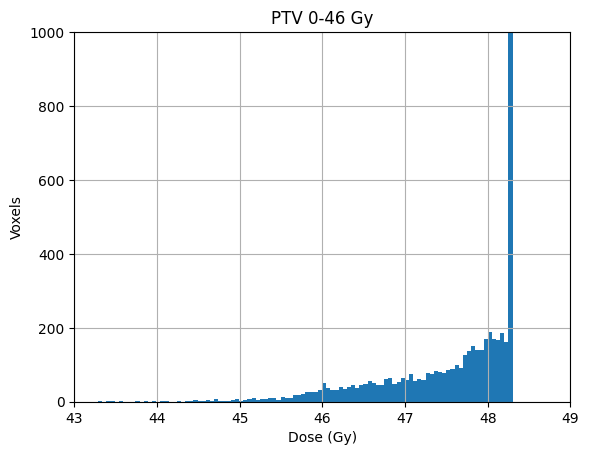

In [76]:
import matplotlib.pyplot as plt

compute_dose(solutionX)

for function in functions:
    if function.type == CostFunction.LTCP:
        roi = rois[function.name]
        p1 = function.parameters[0]
        p2 = function.parameters[1]
        value = np.sum(np.exp(-p2*(roi.dose - p1))/len(roi.dose))
        print('p1', p1)
        print('p2', p2)
        print('value', value)
        print('ROI Dose:', roi.dose)
        plt.hist(roi.dose, bins=100)
        plt.title(roi.name)
        plt.xlabel('Dose (Gy)')
        plt.ylabel('Voxels')
        plt.ylim(0, 1000)
        plt.xticks(np.arange(int(roi.min), int(roi.max) + 2, 1))
        plt.grid()
        plt.show()

p1 46.0
p2 0.82
value 81777547.02844018
ROI Dose: [30.01292927 35.01867956 27.77921863 ... 32.63221828 31.85014865
 31.90355994]


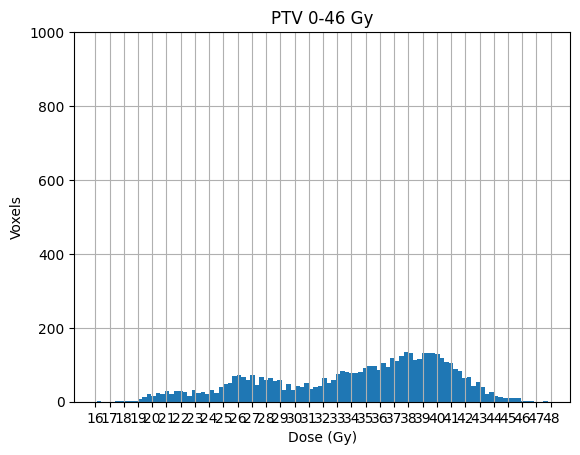

In [77]:
import matplotlib.pyplot as plt

compute_dose(fluence)

for function in functions:
    if function.type == CostFunction.LTCP:
        roi = rois[function.name]
        p1 = function.parameters[0]
        p2 = function.parameters[1]
        # p2 = -0.23
        value = np.sum(np.exp(-p2*(roi.dose - p1))/len(roi.dose))
        print('p1', p1)
        print('p2', p2)
        print('value', value)
        print('ROI Dose:', roi.dose)
     
        plt.hist(roi.dose, bins=100)
        plt.title(roi.name)
        plt.xlabel('Dose (Gy)')
        plt.ylabel('Voxels')
        plt.ylim(0, 1000)
        plt.xticks(np.arange(int(roi.min), int(roi.max) + 2, 1))
        plt.grid()
        plt.show()
        